# Exercise: Layer Types and Neural Network Architectures (Deep Neural Networks)


`#pytorch` `#mnist` `#droupout` `#convolution` `#cnn` `#kernels` `#pooling` `#activation` `#classification` `#normalization`

> Objectives:
>
> - Expand our knowledge of network layers:
>   - Dropout Layers
>   - Convolutional Layers
>   - Pooling Layers
> - Learn about normalization
> - Experiment with, and integrate layers into the design of our model to increase its accuracy.

<small>🚫🤖 AI code generation is not recommended for this notebook.</small>

<small>🙋 Have a suggestion for how to improve this file? Please open an issue for [this repo on GitHub](https://github.com/orgs/deepatlasai/repositories). Create a Help Desk ticket in Discord for time-sensitive technical issues.</small>


## Standard Deep Atlas Exercise Set Up


- [ ] Ensure you are using the coursework Pipenv environment and kernel ([instructions](../SETUP.md))
- [ ] Apply the standard Deep Atlas environment setup process by running this cell:

In [1]:
import sys, os
sys.path.insert(0, os.path.join('..', 'includes'))

import deep_atlas
from deep_atlas import FILL_THIS_IN
deep_atlas.initialize_environment()
if deep_atlas.environment == 'COLAB':
    %pip install -q python-dotenv==1.0.0

🎉 Running in a Virtual environment


### 🚦 Checkpoint: Start

- [ ] Run this cell to record your start time:

In [2]:
deep_atlas.log_start_time()

Started at: 2025-05-08T08:51:25.432458
🚀 Success! Get started...


---


## Context


In this exercise, we will continue our exploration of deep neural networks with PyTorch.

We will also continue to iterate on the design of our MNIST-solving model.

> Note, the PyTorch documentation might refer to "data tensors". This exercise will use the more generalized term "vector". In both cases, they refer to multi-dimensional lists.

There are three parts to this notebook:

1. Recap of what the basic version of our MNIST-solving deep learning model looked like
2. Exploration of common layer types
3. Experimentation by defining a model which uses some of those layers.


## Dependencies


In [3]:
if deep_atlas.environment == 'VIRTUAL':
    !pipenv install ipykernel==6.28.0
    !pipenv install matplotlib==3.8.2 torch==2.1.2 torchvision==0.16.2 torchinfo
if deep_atlas.environment == 'COLAB':
    %pip install matplotlib==3.8.2 torch==2.1.2 torchvision==0.16.2 torchinfo


zsh:1: command not found: pipenv
zsh:1: command not found: pipenv


## Imports


In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

/Users/kevincorstorphine/.local/share/virtualenvs/mli-2025-05-05-coursework-rNXVWyyx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recap


To keep a consistent benchmark, let's load the same data and begin with the same model architecture as we had previously:

- [ ] Run this cell to download the MNIST dataset and load it into training and testing `DataLoader`s:


In [5]:
train_batch_size = 64
test_batch_size = 64

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
trainset = datasets.MNIST(
    "./downloads/mnist",
    download=True,
    train=True,
    transform=transform,
)
testset = datasets.MNIST(
    "./downloads/mnist",
    download=True,
    train=False,
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=True
)

- [ ] Define a device on which PyTorch should run the rest of our code:


In [6]:
# Set the device to run on: GPU, MPS, or CPU
device = torch.device(
    "cpu"
    # if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    # else "cpu"
)
print(f"Using {device} device")

Using cpu device


We will also load our previous model, so that we can compare changes in accuracy.

Here's the design:

```py
# trained with CrossEntropyLoss and the Adam optimizer
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
```

- [ ] Copy the model.pth file produced in the Deep Neural Network exercise and put it in a folder called `downloads` in the current exercise's directory.
- [ ] Check the code below, update the path if necessary, and run the cell to load the model.


In [7]:
model_v1 = torch.load("downloads/mnist.pth")
model_v1 = model_v1.to(device)

- [ ] Test the model's accuracy on the test data:


In [8]:
model_v1.eval()

correct = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images = images.view(images.shape[0], -1).to(device)
        outputs = model_v1(images)
        _, predicted = torch.max(outputs, 1)
        # compute the accuracy of the model
        correct += (predicted == labels.to(device)).sum().item() / labels.shape[0]

print(
    f"Accuracy of model_v1 on test data: {100 * correct / len(testloader)}%"
)

Accuracy of model_v1 on test data: 97.20342356687898%


It should be ≈ 96% (+/- 2% depending on parameter initializations and training hyperparameters in the previous exercise).


## Layer Types


The first version of our MNIST model used _fully-connected_ layers.

- _All_ the outputs of a layer are fed to _all_ nodes in the next layer
  - The ReLU layers performed an extra transformation step but did not otherwise constrain the flow of vectors from one layer to another.

![Sample architecture (incorporating common layer types implemented in PyTorch and similar deep learning libraries)](./assets/layer-types-slide.png)
<small> *Sample architecture (incorporating common layer types implemented in PyTorch and similar deep learning libraries). Source: Layer-Level Architecture lecture.* </small>

However, there are alternatives to full connected layers, a few of which we will explore in this exercise:

- **Dropout** layers: randomly zero out items in a vector.
- **Convolutional** layers: only act on a subset of inputs, defined by a window or "convolution"
- **Pooling** layers: used in conjunction with convolutional layers to reduce the information in a vector to a max value or average value.


In [16]:


# 1. Convolutional Layer (First layer after inputs)
# Convolutional layers apply a filter/kernel to input data to extract features.
# They are particularly effective for image data as they can detect patterns like edges, textures, and shapes.
# The key parameters are:
# - kernel_size: size of the filter window
# - stride: how many pixels to move the filter
# - padding: how to handle edges of the input
# - in_channels: number of input channels (e.g. 1 for grayscale, 3 for RGB)
# - out_channels: number of filters to apply

# 2. Linear Layer (Fully Connected Layer)
# each row of inputs is connected to the next layet via weights. This is a fully connected
# dense layer. The weights can be accessed through the layer's .weight attribute, which contains the learnable parameters that connect inputs to outputs. For example, if you have a linear layer 'layer', you can view its weights with layer.weight.data

# 3. Non-linearity (Activation)
# After summing inputs, the optputs go through an activation function like ReLu or Tanh.
# An activation layer is not strictly required, but it allows the model to learn more complex relationships.

# 4. Dropout Layer (Regularization, represented by the Dice symbol)
# is a regularization technique where some neuron outputs are randomly zeroed out during training.
# This helps prevent overfitting by forcing the model to learn more robust features.

# 5. Layer Normalization (combines outputs across the current layer to have mea= 0 and variance = 1)
# This helps prevent overfitting by forcing the model to learn more robust features.

# 6. Final Linear + Activation (another fully connected layer, followed by a softmax activation function)
# This takes the output of the previous layer and applies a linear transformation to it.
# The softmax activation function then converts the output into a probability distribution over the classes.















## Dropout Layers


The benefit of dropout layers is that they prevent "co-adaptation" of neurons in the network: where one probability-detecting neuron is only useful in the presence of another.

It does so by introducing noise to a vector, which in turn makes neurons more resilient and less prone to overfitting on small datasets.

Let's see the effects on a sample vector:

- [ ] `m` should be `Dropout` layer
  - The constructor accepts an argument `p` which represents the probability that any given member of the input will be set to zero. Try `0.2`.


In [9]:
# Generate a random 2D vector
input = torch.randn(5, 5)

m = nn.Dropout(p=0.1)

output = m(input)

print("Input:\n", input)
print("Output:\n", output)

Input:
 tensor([[ 0.9731,  0.2186,  0.7732, -0.8423, -0.5928],
        [ 1.3252, -0.0216,  0.3240, -0.2211,  0.1558],
        [ 1.3790, -2.3139,  0.2732, -1.0593, -0.9202],
        [ 0.2559, -1.7413, -0.8823, -0.1295, -0.0411],
        [-1.3713,  1.3894,  0.3322, -1.6010,  0.4678]])
Output:
 tensor([[ 1.0813,  0.2429,  0.8592, -0.9359, -0.6586],
        [ 1.4724, -0.0240,  0.3600, -0.0000,  0.1731],
        [ 1.5322, -2.5710,  0.3035, -1.1771, -0.0000],
        [ 0.2843, -1.9347, -0.9804, -0.1438, -0.0457],
        [-1.5237,  0.0000,  0.3691, -1.7789,  0.5198]])


<details><summary>Solution:</summary>

```py
m = nn.Dropout(p=0.1)
```

</details>


- [ ] Run the cell above multiple times and note the differences:
  - values are randomly set to 0, and surrounding values are also changed by lesser amounts (i.e. they are affected by noise)


## Convolutional Layers


Convolutional layers are so named because they slide a "convolving", dot-product filter (also known as a kernel or convolution) across the input vector, arranged in a matrix of rank 2 or more. 

The dot-product of the filter, and the values in the area covered by filter, produces a new value in the output matrix. 

The downsides of using only `Linear` layers for training on spatially-structured vectors (e.g. images) are that

- Each value in the input vector is treated as its own value disconnected from the rest, losing spatial relationships.
- Each value in the input vector must get its own input node (fine for a 28×28px image but practically infeasible for 1 megapixel images and beyond — they would need at least one million nodes in the input layer alone).

Convolutional layers provide these benefits:

- Retain spatial relationships while increasing or reducing dimensionality.
- Parameter efficiency
  - Transformations happen on windows as opposed to individual members of the input vector (i.e. pixels in this exercise)
- Feature learning: they focus on local features in the data

Convolution filters can enhance or diffuse features in the input. Classical image processing techniques use them for edge detection, sharpening, blurring etc. In deep learning contexts, the filters themselves are updated as part of backpropagation. 

- [ ] Here's a visual depiction of this process (using a sharpening filter):

![Animation of the effects of 2D convolutional layer on an input](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

_The animation above illustrates the effects of a sharpening filter, used to exaggerate the contrast of surrounding pixels. Other common filters include smoothing filters (blurs) and edge detectors._

_Also note that the input and filter in the animation are represented as 2 dimensional matrices. Images with color information can have another dimension: red, green, and blue "color depth" values for each pixel._


Let's take a look at a PyTorch example:

- [ ] Instantiate a `Conv2d` layer, `m`
  - Specify the following arguments:
    - [ ] `in_channels`: The number of "color" channels in the input. Note that the example input only has a single grayscale channel.
    - [ ] `out_channels`: The number of filters applied by the layer to a given window (see animation above) / the "depth" of the output vector.
      - It represents the number of features extracted from the input data by the convolutional layer, with each filter learning different patterns and producing its own output channel. Try `1`.
    - [ ] `kernel_size`: The size of the filter window. `3` will create a 3×3px window with the same depth as the input vector.
    - [ ] `stride`: How many pixels should the filter shift by before applying the convolution again. Try `1`.
    - [ ] `padding`: Adds a border to the image so that pixels on the edge do not get deprioritized (the gray border in the animation). Try `0`.
- [ ] Run the cell below and examine the output.
  - [ ] Change parameters such as `out_channels`, `stride`, and `padding` and examine the results.


In [17]:
input = torch.randn(1, 5, 5)  # Simulate a 5×5 grayscale image

m = nn.Conv2d(
    in_channels=1,  # Single grayscale channel
    out_channels=1,  # Single output channel
    kernel_size=3,   # 3x3 filter window
    stride=1,        # Move 1 pixel at a time
    padding=0        # No padding
)

print(input)
print(m(input))

tensor([[[-1.2441e+00, -1.4077e+00, -3.2542e-01,  8.3767e-02,  7.7320e-01],
         [-3.9577e-01, -7.2819e-01, -1.4392e+00,  4.1898e-01, -5.7208e-01],
         [ 3.0559e-01, -2.9803e-02,  2.1563e-01,  7.4959e-01,  2.4539e-01],
         [ 1.7299e-01, -8.4933e-01, -4.8695e-01, -1.4438e+00,  1.7805e-03],
         [-7.1939e-01, -1.5912e+00, -2.2434e+00, -4.2881e-03,  8.6007e-01]]])
tensor([[[ 0.1375,  0.2292,  0.6697],
         [ 0.2192, -0.3522,  0.1763],
         [-0.1872,  0.4852,  0.2409]]], grad_fn=<SqueezeBackward1>)


<details><summary>Solution:</summary>

```py
m = nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0
)
```

</details>


## Pooling Layers


Pooling layers are similar to convolutional layers because they also perform a sliding window operation on the vector.

But rather than perform a convolving filter, which could result in increased dimensionality, the operation always returns a single value (dimensionality reduction). For example:

- Max-Pooling returns the maximum value from a vector.
- Average-Pooling returns the average of a vector.

Pooling layers help with

- Translation Invariance: By aggregating information from local regions, pooling layers are less sensitive to small variations in the input, which can improve the model's ability to recognize patterns in different positions.
- Downsampling the data to control the size of vectors and reduce computation.

Let's explore:

- [ ] Set `m` to be an instance of `nn.MaxPool2d`
  - Set the following parameters:
    - `kernel_size`: The size of the window. Try `3`
    - `stride`: How much the window should move. Try `3` here as well.
- [ ] Run the cell and examine the output.
  - Note the reduction in information and where the result values came from.
- [ ] Try `nn.AvgPool2d` instead.


In [11]:
input = torch.randn(1, 6, 6)  # Simulate a 5×5 grayscale image

m = nn.MaxPool2d(kernel_size=3, stride=3)

print(input)
print(m(input))

tensor([[[-0.7876,  1.0587, -0.1138,  0.5766,  0.3298,  0.4056],
         [-1.4699, -0.8204,  1.2199, -0.0135,  1.7380,  0.2948],
         [ 0.4333, -1.4598, -0.9739,  1.0937,  1.1211,  2.3880],
         [ 0.2236,  0.8393, -0.8139,  2.2223,  0.3852,  1.2925],
         [ 0.6454,  0.0765, -0.3277,  0.5946,  1.3998,  1.1152],
         [-1.8419, -0.0388,  1.1128,  1.4583,  0.9063,  0.9559]]])
tensor([[[1.2199, 2.3880],
         [1.1128, 2.2223]]])


<details><summary>Solution:</summary>

```py
m = nn.MaxPool2d(kernel_size=3, stride=3)
```

</details>


## Activation Layers


In addition to the primary layer types — Linear (a.k.a Fully-Connected), Dropout, Convolutional, and Pooling — PyTorch also gives us options for activation layers.

These layers apply some transformation function to the output of another layer without reshaping, dropping, convolving, or aggregating the vectors themselves.

A non-exhaustive list of activations

- **ReLU** (Rectified Linear Unit):
  - `relu(x) = max(0,x)`
  - Converts all negative values to zero, leaves all positive values as-is.
- **Sigmoid**:
  - `σ(x)= 1/(1+e^−x)`
  - Maps values to between 0 and 1 along an S-shaped curve.
- **Tanh** (Hyperbolic Tangent):
  - `tanh(x) = (e^x - e^−x)/(e^x + e^−x)`
  - Similar to the sigmoid but ranging from -1 to 1, for zero-centered outputs.
- **Softmax**:
  - `softmax(Scores)_i = exponentiated score for class i / sum of exponentiated scores`
  - Used to map a list of raw scores to a list of probabilities (all the values sum up to 1).
  - Used for classification problems.
    - Performed automatically by the `CrossEntropyLoss` function used to train `model_v1`

There is also _linear activation_ which amounts to no transformation of the values in the vector.

ReLU is very common given it's relatively quick computation and performance in ML experiments.

Plots of the outputs of activation functions can be found [here](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions).


## Flattening and Reshaping


Note that `Conv2d` layers can greatly increase the dimensionality of the input data. Pooling layers can decrease them. But in order to feed data into a `Linear` layer, it will need to be _flattened_ to a list of values.

- [ ] Call `torch.flatten` and pass in the example multidimensional vector, `t`:


In [12]:
t = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

output = torch.flatten(t)

print("Output:\n", output)

Output:
 tensor([1, 2, 3, 4, 5, 6, 7, 8])


<details><summary>Solution:</summary>

```py
output = torch.flatten(t)
```

</details>


Flattening is generalization of _reshaping_: taking a vector's value and feeding them into a new arrangement of nested arrays.

- [ ] Call `torch.reshape` and pass in
  - [ ] `t`, a sample vector of shape 4×6
  - [ ] a new shape for the values, `(3, 8)`, 3x8


In [13]:
t = torch.randn(4, 6)

output = torch.reshape(t, (3, 8))

print("Input:\n", t)
print("Output:\n", output)

Input:
 tensor([[ 0.2572, -0.8055,  0.9213, -0.6534,  0.2070,  0.8520],
        [ 1.8250, -0.5088, -0.4075, -0.1327,  1.5259,  0.5126],
        [ 0.5661, -0.7786,  0.6103, -0.8960,  0.2566,  0.6437],
        [-0.9917,  0.1949, -1.3241,  1.1319,  1.0798,  1.5011]])
Output:
 tensor([[ 0.2572, -0.8055,  0.9213, -0.6534,  0.2070,  0.8520,  1.8250, -0.5088],
        [-0.4075, -0.1327,  1.5259,  0.5126,  0.5661, -0.7786,  0.6103, -0.8960],
        [ 0.2566,  0.6437, -0.9917,  0.1949, -1.3241,  1.1319,  1.0798,  1.5011]])


<details><summary>Solution:</summary>

```py
output = torch.reshape(t, (3, 8))
```

</details>


- Note that `flatten` and `reshape` are not layer types but are often necessary when bridging layers with incompatible outputs and inputs.


## Experimentation


The order and parameters of layers in a model are usually derived by experimentation by ML researchers: New layer types, orderings, activation layers etc. are implemented and the resulting models are benchmarked against the previous best models. ML researchers often publish their findings in academic papers.

The goal in this exercise is not to publish a paper but engage in similar experimentation using some of the tools covered here.

- [ ] In the following cell, design a new model which — at minimum — uses a convolutional and pooling layer, alongside any linear and ReLU layers.
  - The provided code uses the object-oriented PyTorch API for defining models.
    - `_init_` allows you to define each layer
      - You only have to define a particular layer once; e.g. if you use ReLU after every convolutional layer, you can specify `self.relu = nn.ReLU()` once and reference it multiple times in `forward()`
    - `forward` allows you to specify how the output of each layer is passed to the next, offering more control than `nn.Sequential`
    - [ ] Refactor the code to use `nn.Sequential` if that is preferable.

An example starting point:

```
↳ input                           => 1×28×28 vector (image data)
↳ Conv2d    with 10 out_channels  => 10×28×28 vector
↳ ReLU                            => 10×28×28 vector
↳ MaxPool2d with a 2×2 kernel     => 10×14×14 vector
↳ Conv2d    with 20 out_channels  => 20×14×14 vector
↳ ReLU      (same)                => 20×14×14 vector
↳ MaxPool2d (same)                => 20×7×7 vector
↳ Reshape   flatten               => 980-length vector
↳ Linear    output 128 dimensions => 128-length vector
↳ ReLU      (same)                => 128-length vector
↳ Dropout   p of 0.5              => 128-length vector
↳ Linear    output 10 dimensions  => 10-length vector (class probabilities)
```

- [ ] (Hint) Try asking Copilot to write the `MNISTClassifier` class based on the layer descriptions above!
- [ ] Train and test your model
  - You may copy code from your previous deep neural network implementation
  - Feel free to break up the following cell depending on what variables you are tweaking.

<small>⏱️ Expected training time: 2–10 minutes:</small>

Layer (type:depth-idx)                   Output Shape              Param #
MNISTClassifier                          [64, 10]                  --
├─Conv2d: 1-1                            [64, 10, 28, 28]          260
├─Conv2d: 1-2                            [64, 20, 14, 14]          5,020
├─Linear: 1-3                            [64, 128]                 125,568
├─Dropout: 1-4                           [64, 128]                 --
├─Linear: 1-5                            [64, 10]                  1,290
Total params: 132,138
Trainable params: 132,138
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 84.14
Input size (MB): 0.20
Forward/backward pass size (MB): 6.09
Params size (MB): 0.53
Estimated Total Size (MB): 6.82
Epoch: 1,	Training loss: 0.23401104464038794


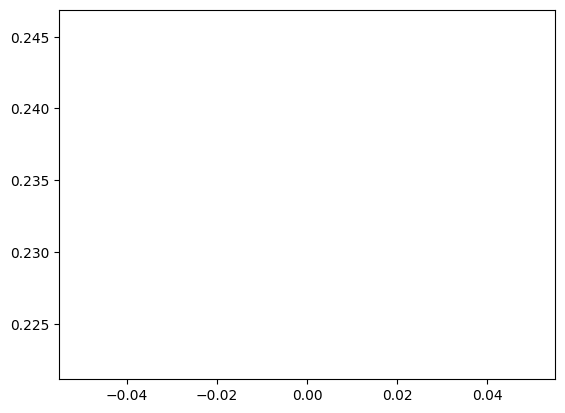

Epoch: 2,	Training loss: 0.09136260064643448


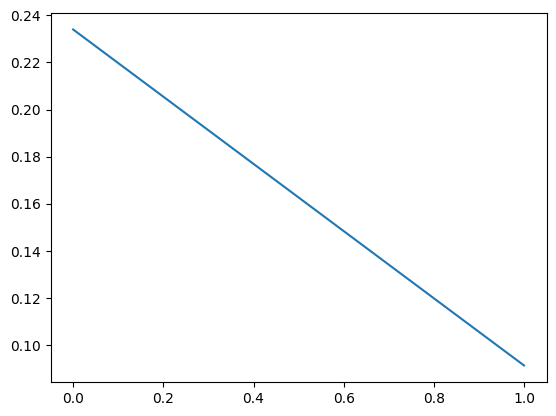

Epoch: 3,	Training loss: 0.07597529293981933


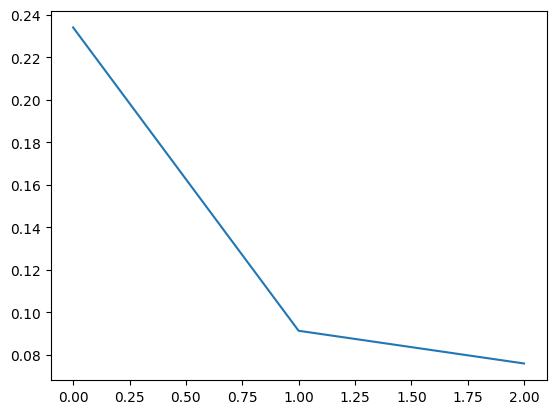

Epoch: 4,	Training loss: 0.06562854503515983


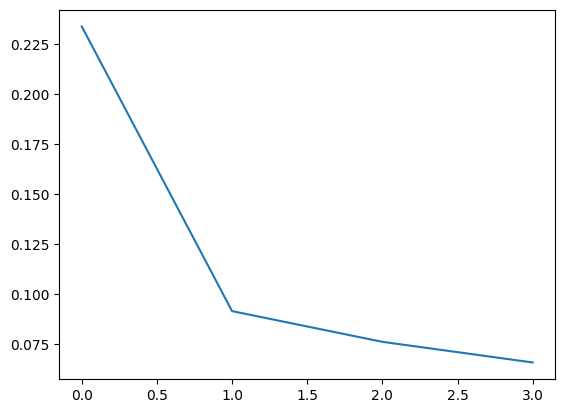

Epoch: 5,	Training loss: 0.0587110646624722


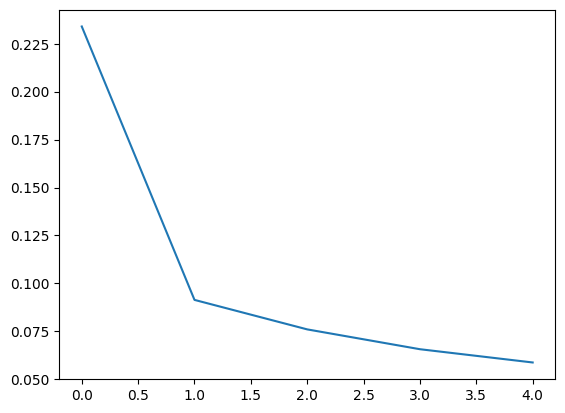

Epoch: 6,	Training loss: 0.056989616432005286


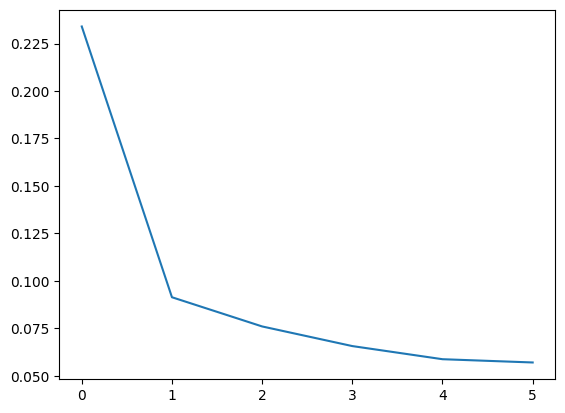

Epoch: 7,	Training loss: 0.04892281149830966


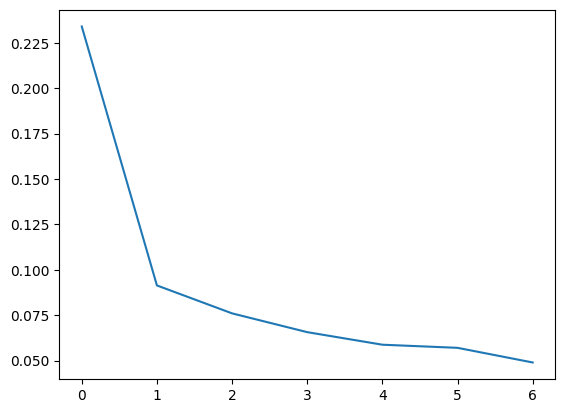

Epoch: 8,	Training loss: 0.048179952599342664


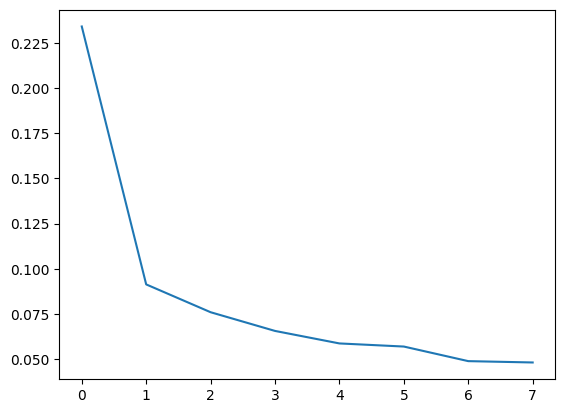

Epoch: 9,	Training loss: 0.04433773380930042


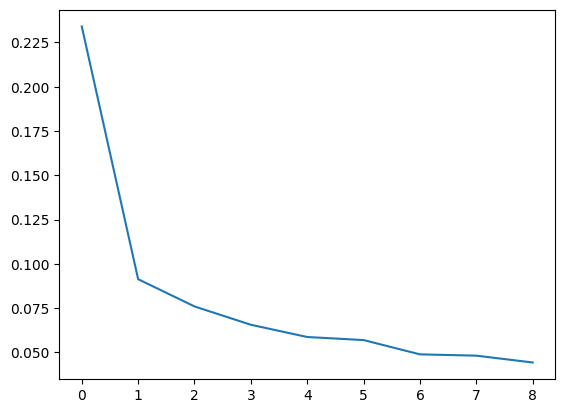

Epoch: 10,	Training loss: 0.043154183369893205


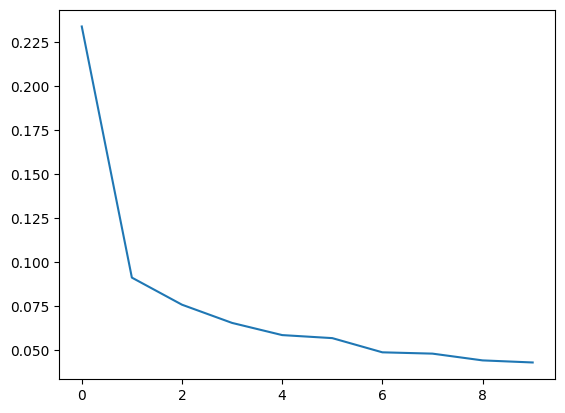

Epoch: 11,	Training loss: 0.039768614066494706


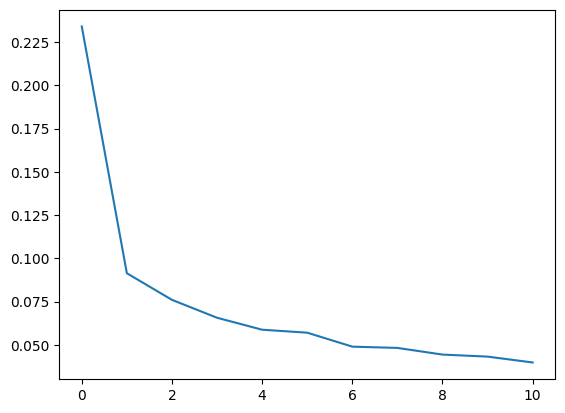

Epoch: 12,	Training loss: 0.04296186541077812


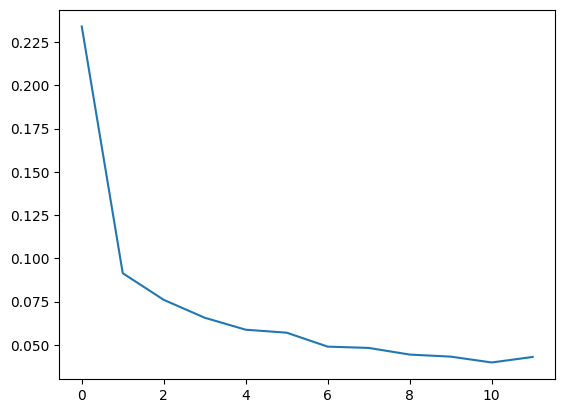

Accuracy of model_v2 on test data: 98.87539808917198%


In [15]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        # conv1 is the first convolutional layer. 
        # It takes an input of 1 channel (grayscale image) and produces 10 output channels.
        # The kernel size is 5x5, and the padding is 2.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        # conv2 is the second convolutional layer.
        # It takes an input of 10 channels (from conv1) and produces 20 output channels.
        # The kernel size is 5x5, and the padding is 2.
        # there are more outputs from your second convolutional layer due to how convolutional networks
        # learn features.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        # fc1 is the first fully connected layer. (aka linear layer)
        # It takes an input of 980 values (from the flattened output of conv2) and produces 128 outputs.
        # flattening is the process of converting multi-dimensional data (like 2d or 3d featture maps) into one-dimensional vecotor.
        # This flattening is a crucial step when transitioning from convolutional layers to fully connected layers.
        self.fc1 = nn.Linear(980, 128)
        # fc2 is the second fully connected layer.
        # It takes an input of 128 values (from fc1) and produces 10 outputs.
        self.fc2 = nn.Linear(128, 10)
        # dropout is a dropout layer. a dropout layet is a regularization technique used in neural networks.
        # it randomly zeroes out some of the neurons in the network during training, which helps prevent overfitting.
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)                    # Apply first conv layer (1->10 channels)
        x = nn.functional.relu(x)            # Apply ReLU activation (activation functions introduce non-linearity into the network which mkes them bette at complex patterns)
        x = nn.functional.max_pool2d(x, 2)   # Reduce spatial dimensions by half (28x28 -> 14x14)# Reduce spatial dimensions by half (28x28 -> 14x14) to decrease computation and extract important features
        
        # Second convolutional block
        x = self.conv2(x)                    # Apply second conv layer (10->20 channels)
        x = nn.functional.relu(x)            # Apply ReLU activation
        x = nn.functional.max_pool2d(x, 2)   # Reduce spatial dimensions by half (14x14 -> 7x7)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)           # Flatten 20x7x7 tensor to 980-length vector
        x = self.fc1(x)                      # First fully connected layer (980->128)
        x = nn.functional.relu(x)            # Apply ReLU activation
        x = self.dropout(x)                  # Apply dropout for regularization
        x = self.fc2(x)                      # Final fully connected layer (128->10)
        return x                             # Return logits for 10 classes


# Create an instance of the MNISTClassifier neural network
# This classifier is designed to recognize handwritten digits (0-9) from the MNIST dataset
# It uses a CNN architecture with 2 convolutional layers and 2 fully connected layers
model_v2 = MNISTClassifier()
print(summary(model_v2, input_size=(64, 1, 28, 28)))
model_v2.to(device)

# Define the loss function
# (Make sure to remove any softmax layers if you choose CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
# An optimizer is an algorithm that adjusts the model's parameters (weights and biases) to minimize the loss function
# It uses gradient descent to update parameters in the direction that reduces the loss
# Common optimizers include SGD, Adam, RMSprop - each with different strategies for parameter updates
optimizer = optim.Adam(model_v2.parameters(), lr=0.003)

# Train the model
losses = []
epochs = 12

for e in range(epochs):  # Loop through each training epoch
    total_loss = 0  # Initialize loss accumulator for this epoch
    for images, labels in trainloader:  # Iterate through batches of training data
        # Reshape images to (batch_size, channels, height, width) and move to device
        images = images.view(images.shape[0], 1, 28, 28).to(device)
        labels = labels.to(device)  # Move labels to device (GPU/CPU)
        # Forward pass: compute predictions using the model
        predictions = model_v2(images)
        # Calculate loss between predictions and true labels
        loss = loss_fn(predictions, labels)
        # Clear previous gradients
        optimizer.zero_grad()
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters using computed gradients
        optimizer.step()
        # Accumulate loss for this batch
        total_loss += loss.item()

    # Calculate average loss for this epoch by dividing total loss by number of batches
    epoch_loss = total_loss / len(trainloader)
    
    # Print current epoch number and its average training loss
    print(f"Epoch: {e+1},\tTraining loss: {epoch_loss}")
    
    # Store the epoch's loss in our list for later plotting
    losses.append(epoch_loss)

    # Create a line plot of all losses so far to visualize training progress
    plt.plot(losses)
    plt.show()

# Test the model's accuracy
correct = 0
model_v2.eval()  # Turn off dropout

with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images = images.view(images.shape[0], 1, 28, 28).to(device)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        # compute the accuracy of the model
        correct += (predicted == labels.to(device)).sum().item() / labels.shape[0]

print(
    f"Accuracy of model_v2 on test data: {100 * correct / len(testloader)}%"
)



<details><summary>Solution:</summary>

```py
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(980, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model_v2 = MNISTClassifier()
print(summary(model_v2, input_size=(64, 1, 28, 28)))
model_v2.to(device)

# Define the loss function
# (Make sure to remove any softmax layers if you choose CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model_v2.parameters(), lr=0.003)

# Train the model
losses = []
epochs = 12

for e in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], 1, 28, 28).to(device)
        labels = labels.to(device)
        predictions = model_v2(images)
        loss = loss_fn(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(trainloader)
    print(f"Epoch: {e+1},\tTraining loss: {epoch_loss}")
    losses.append(epoch_loss)

    plt.plot(losses)
    plt.show()

# Test the model's accuracy
correct = 0
model_v2.eval()  # Turn off dropout

with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images = images.view(images.shape[0], 1, 28, 28).to(device)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        # compute the accuracy of the model
        correct += (predicted == labels.to(device)).sum().item() / labels.shape[0]

print(
    f"Accuracy of model_v2 on test data: {100 * correct / len(testloader)}%"
)
```

</details>


### 🚦 Checkpoint: Stop

- [ ] Uncomment this code
- [ ] Complete the feedback form
- [ ] Run the cell to log your responses and record your stop time:

In [ ]:
deep_atlas.log_feedback(
    {
        # How long were you actively focused on this section? (HH:MM)
        "active_time": FILL_THIS_IN,
        # Did you feel finished with this section (Yes/No):
        "finished": FILL_THIS_IN,
        # How much did you enjoy this section? (1–5)
        "enjoyment": FILL_THIS_IN,
        # How useful was this section? (1–5)
        "usefulness": FILL_THIS_IN,
        # Did you skip any steps?
        "skipped_steps": [FILL_THIS_IN],
        # Any obvious opportunities for improvement?
        "suggestions": [FILL_THIS_IN],
    }
)
deep_atlas.log_stop_time()

## You did it!


- [ ] Remember to save versions of your model alongside notes about the architectures and any hypotheses used to design them.


## Resources


- [ ] [PyTorch documentation](https://pytorch.org/docs/stable/index.html)
- [ ] [PyTorch implementation of AlexNet](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py) (Winner — ImageNet Large Scale Visual Recognition Challenge, 2012)
  - This is a general image classification model
  - Having completed this notebook, you should be able to follow the implementation of the AlexNet class which defines the network architecture.
